### Minh Vo
### ADSP 32018 - Natural Language Processing and Cognitive Computing (Autumn 23)
### FINAL PROJECT

### Sentiment Analysis

In [1]:
# !pip install ktrain
# !pip install vaderSentiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import os, requests, sys
import nltk as nltk

from joblib import dump, load

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import ktrain
from ktrain import text

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [2]:
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 20


In [3]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)
workers=num_processors

INFO: Pandarallel will run on 19 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


#### Yelp Data Loading

In [60]:
# import yelp data
directory = 'https://storage.googleapis.com/msca-bdp-data-open/yelp/'
fileName = 'yelp_train_sentiment.json'

path = directory + fileName

yelp = pd.read_json(path, orient='records', lines=True)
print(yelp.shape)
yelp.head()

(255717, 3)


,text,label,lang
0,"I love Deagan's. I do. I really do. The atmosphere is cozy and festive. The shrimp tacos and house fries are my standbys. The fries are sometimes good and sometimes great, and the spicy dipping sauce they come with is to die for. The beer list is amazing and the cocktails are great. The prices are mid-level, so it's not a cheap dive you can go to every week, but rather a treat when you do. Try it out. You won't be disappointed!",1,en
1,I love the classes at this gym. Zumba and. Radio Hip Hop are my favorite. This is such a great fun and I love that it is so reasonably priced!,1,en
2,The tables and floor were dirty. I was the only customer on a Saturday nite and the person working the counter ignored me I had a corned beef sandwich. I took three bites and threw it in the trash,0,en
3,"I had an oil change at the 15515 N Scottsdale Road location. When the car was delivered to me, there were two engine warning lights on that had not been on when I drove the car in. The technician said that the lights were on when he got in the car, which was not true. I took the car to the dealer who said that a sensor light had been left unplugged when they removed the air filter. I should have read the many bad Yelp reviews prior to going to this facility.",0,en
4,"The absolute WORST apartment complex I have ever lived in. Moved here from out of state. Hoped to find a decently priced apartment until I got myself settled in. Wow this place has been trash. Landlord is only here half the time, so those of you with a full time job, forget ever trying to communicate with her! Doesn't answer the phone or call back. Place can't even get with the 21st century and splurge on email communication. Rent past due? Noise complaint on an animal? Anything, Don't worry...",0,en


label = 0 >> Negative Sentiment  
label = 1 >> Positive Sentiment  

##### Data Preprocessing

In [61]:
sentiment = {0: "Negative", 1: "Positive"}
yelp['sentiment'] = yelp['label'].map(sentiment)

In [62]:
yelp.head(3)

,text,label,lang,sentiment
0,"I love Deagan's. I do. I really do. The atmosphere is cozy and festive. The shrimp tacos and house fries are my standbys. The fries are sometimes good and sometimes great, and the spicy dipping sauce they come with is to die for. The beer list is amazing and the cocktails are great. The prices are mid-level, so it's not a cheap dive you can go to every week, but rather a treat when you do. Try it out. You won't be disappointed!",1,en,Positive
1,I love the classes at this gym. Zumba and. Radio Hip Hop are my favorite. This is such a great fun and I love that it is so reasonably priced!,1,en,Positive
2,The tables and floor were dirty. I was the only customer on a Saturday nite and the person working the counter ignored me I had a corned beef sandwich. I took three bites and threw it in the trash,0,en,Negative


In [63]:
yelp['sentiment'].value_counts()

sentiment
Negative    127995
Positive    127722
Name: count, dtype: int64

In [64]:
yelp['label'].value_counts()

label
0    127995
1    127722
Name: count, dtype: int64

In [65]:
# define X and y
X = yelp['text']
y = yelp['label']
print(X.shape)
print(y.shape)

(255717,)
(255717,)


In [66]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(191787,)
(63930,)
(191787,)
(63930,)


##### Naive Bayes

In [67]:
%%time

pipe_nb = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    MultinomialNB()
)
pipe_nb.fit(X_train, y_train)
y_pred_class = pipe_nb.predict(X_test)

CPU times: total: 1min 16s
Wall time: 1min 47s


In [68]:
# calculate accuracy of class predictions
nb_accuracy = accuracy_score(y_test, y_pred_class)
print(f"Test Accuracy: {nb_accuracy * 100:.1f}%")

Test Accuracy: 94.6%


In [69]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     32016
           1       0.98      0.91      0.94     31914

    accuracy                           0.95     63930
   macro avg       0.95      0.95      0.95     63930
weighted avg       0.95      0.95      0.95     63930



In [70]:
%time dump(pipe_nb, "nb.joblib")

CPU times: total: 39.8 s
Wall time: 53.9 s


['nb.joblib']

##### Logistics Regression

In [71]:
%%time

pipe_logreg = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    LogisticRegression()
)
pipe_logreg.fit(X_train, y_train)
y_pred_class2 = pipe_logreg.predict(X_test)

CPU times: total: 3min 15s
Wall time: 5min


In [72]:
logreg_accuracy = accuracy_score(y_test, y_pred_class2)
print(f"Test Accuracy: {logreg_accuracy * 100:.1f}%")

Test Accuracy: 96.5%


In [73]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class2))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     32016
           1       0.97      0.96      0.96     31914

    accuracy                           0.96     63930
   macro avg       0.96      0.96      0.96     63930
weighted avg       0.96      0.96      0.96     63930



In [74]:
%time dump(pipe_logreg, "logreg.joblib")

CPU times: total: 16.2 s
Wall time: 50.6 s


['logreg.joblib']

##### Support Vector Machines

In [75]:
%%time

pipe_svm = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    SGDClassifier(max_iter=100, tol=None)
)
pipe_svm.fit(X_train, y_train)
y_pred_class3 = pipe_svm.predict(X_test)

CPU times: total: 1min 39s
Wall time: 2min 5s


In [76]:
# calculate accuracy of class predictions
svm_accuracy = accuracy_score(y_test, y_pred_class3)
print(f"Test Accuracy: {svm_accuracy * 100:.1f}%")

Test Accuracy: 95.6%


In [77]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class3))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     32016
           1       0.96      0.95      0.96     31914

    accuracy                           0.96     63930
   macro avg       0.96      0.96      0.96     63930
weighted avg       0.96      0.96      0.96     63930



In [78]:
%time dump(pipe_svm, "svm.joblib")

CPU times: total: 48.9 s
Wall time: 49.5 s


['svm.joblib']

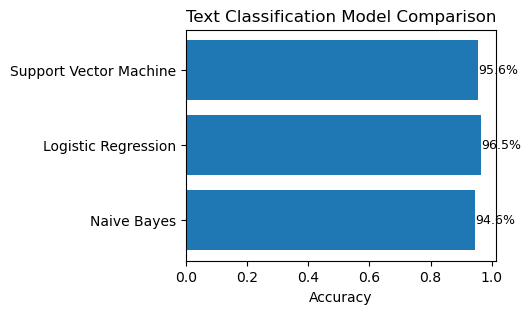

In [24]:
accuracy_scores = [nb_accuracy, logreg_accuracy, svm_accuracy]
model_names = ['Naive Bayes', 'Logistic Regression', 'Support Vector Machine']

# Create a bar chart to compare model performance
plt.figure(figsize=(4,3))
plt.barh(model_names, accuracy_scores)
plt.xlabel('Accuracy')
plt.title('Text Classification Model Comparison')

for i, score in enumerate(accuracy_scores):
    plt.text(score, i, f'{score*100:.1f}%', va='center', fontsize=9)

plt.show()

Logis

#### Predictions on News Data

In [4]:
%%time

cleaned_news_df = pd.read_parquet('final_cleaned_news_df.parquet', engine = 'pyarrow')

print(f'Cleaned data contains {cleaned_news_df.shape[0]:,.0f} news articles')

Cleaned data contains 191,487 news articles
CPU times: total: 6.92 s
Wall time: 36.5 s


In [5]:
cleaned_news_df.head(3)

,url,date,language,title,text,cleaned_title,cleaned_text,text_word_count,lemmatized_title,lemmatized_text
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis galus australis wednesday february trending needle counters market comprehensive study companies medline industries boen healthcare skin scrub trays market comprehensive study companies medline industries bd deroyal global portable handheld electronic game machine market outlook business insights apollo games sony aristocrat leisure igt infectious dise...,666,legaltech artificial intelligence market technology advancement catalyst repository system,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensive study company veterinary market comprehensive study company hein...
1,http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html,2021-07-05,en,"Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef","\n\nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef\n\n \nHome |\nNASA Watch\nSpaceRef Business\nAstrobiology Web\nAdvertising\nAdd an Event\nSign up for our Daily Newsletter \n\n \n\n\nInternational Space Station\nNASA Hack Space\nCalendar\nMissions\nSpace Weather \n \n \nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe\n\n\n Press Release - Source: NATIONAL INSTITUTES OF NATURAL SCIENCES...",observation simulation ai join forces reveal clear universe spaceref,observation simulation ai join forces reveal clear universe spaceref nasa watch spaceref business astrobiology web advertising add event sign daily international space station nasa hack space calendar missions space weather observation simulation ai join forces reveal clear universe press release source national institutes natural sciences posted july pm view using ai driven data analysis peel back noise find actual shape universe credit institute statistical mathematics japanese astronomers...,587,observation simulation ai join force reveal clear universe spaceref,observation simulation ai join force reveal clear universe watch business astrobiology web advertising add event international space station hack space calendar mission space weather observation simulation ai join force reveal clear universe press release source national natural science post pm view use ai drive datum analysis peel back noise find actual shape universe credit statistical japanese astronomer develop new artificial intelligence ai technique remove noise astronomical datum due ...
2,http://usw

In [6]:
%time 

pipe_nb = load("nb.joblib")
pipe_logreg = load("logreg.joblib")
pipe_svm = load("svm.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


##### Naives Bayes

In [7]:
%%time

cleaned_news_df2 = cleaned_news_df.copy()

nb_pred = pipe_nb.predict(cleaned_news_df2['lemmatized_text'])

cleaned_news_df2['Sentiments_NB'] = nb_pred
cleaned_news_df2['Sentiments_NB'].value_counts()

CPU times: total: 2min 22s
Wall time: 5min 42s


Sentiments_NB
0    190186
1      1301
Name: count, dtype: int64

##### Logistics Regression

In [8]:
%%time

logreg_pred = pipe_logreg.predict(cleaned_news_df2['lemmatized_text'])

cleaned_news_df2['Sentiments_LR'] = logreg_pred
cleaned_news_df2['Sentiments_LR'].value_counts()

CPU times: total: 1min 1s
Wall time: 5min 52s


Sentiments_LR
0    156606
1     34881
Name: count, dtype: int64

##### Support Vector Machines

In [9]:
%%time

svm_pred = pipe_svm.predict(cleaned_news_df2['lemmatized_text'])

cleaned_news_df2['Sentiments_SVM'] = svm_pred
cleaned_news_df2['Sentiments_SVM'].value_counts()

CPU times: total: 52.3 s
Wall time: 5min 42s


Sentiments_SVM
0    168625
1     22862
Name: count, dtype: int64

Plot the results of these 3 models

In [6]:
pretrain_yelp_models = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'Support Vector Machines'],
    'Positive': [1301, 34881, 22862],
    'Negative': [190186, 156606, 168625]
    })
pretrain_yelp_models.sort_values(by='Positive', ascending=True)
pretrain_yelp_models

,Model,Positive,Negative
0,Naive Bayes,1301,190186
1,Logistic Regression,34881,156606
2,Support Vector Machines,22862,168625


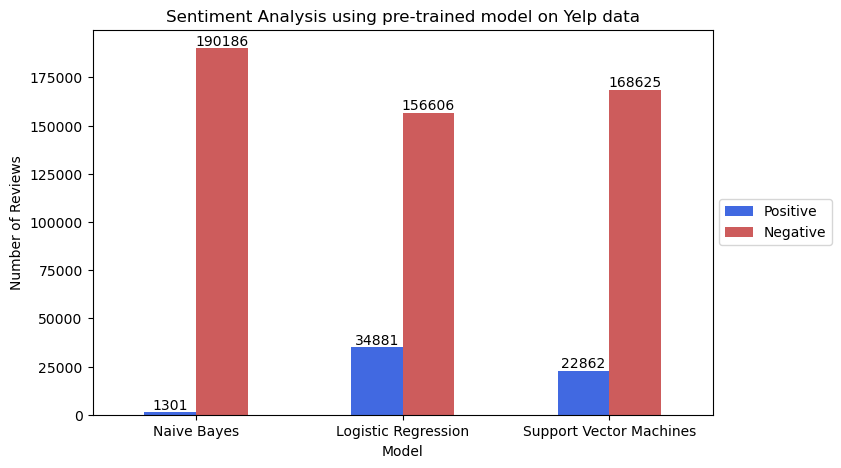

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
bars = pretrain_yelp_models.plot(kind='bar', x='Model', y=['Positive', 'Negative'], color=['royalblue', 'indianred'], ax=ax)

for bar in bars.containers:
    bars.bar_label(bar)
    
ax.set_title("Sentiment Analysis using pre-trained model on Yelp data")
ax.set_xlabel("Model")
ax.set_ylabel("Number of Reviews")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.show()

##### Timing Vader with parallelization

In [10]:
%%time

# cleaned_news_df2 = cleaned_news_df.copy()

analyzer = SentimentIntensityAnalyzer()

sentiment_vader = pd.DataFrame()
sentiment_vader['vader'] = cleaned_news_df2['cleaned_text'].parallel_apply(analyzer.polarity_scores)
sentiment_vader = pd.DataFrame(sentiment_vader['vader'].tolist())

# Create a positive / negative sentiment variable
sentiment_vader['sentiment'] = np.where(sentiment_vader['compound'].astype(float) > 0, 'Positive', 'Negative')
sentiment_vader['sentiment'] = np.where(sentiment_vader['compound'].astype(float) == 0, 'Neutral', sentiment_vader['sentiment'])

# Merge Vader values with Sentiments
sentiment_vader.rename(columns={'sentiment': 'Sentiment_VADER'}, inplace=True)
cleaned_news_df2 = pd.merge(cleaned_news_df2, sentiment_vader[['Sentiment_VADER', 'compound']], left_index=True, right_index=True)

CPU times: total: 7.36 s
Wall time: 8min 54s


In [11]:
cleaned_news_df2[['cleaned_text', 'lemmatized_text', 'Sentiment_VADER', 'compound']].head()

,cleaned_text,lemmatized_text,Sentiment_VADER,compound
0,legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis galus australis wednesday february trending needle counters market comprehensive study companies medline industries boen healthcare skin scrub trays market comprehensive study companies medline industries bd deroyal global portable handheld electronic game machine market outlook business insights apollo games sony aristocrat leisure igt infectious dise...,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensive study company veterinary market comprehensive study company hein...,Positive,0.9990
1,observation simulation ai join forces reveal clear universe spaceref nasa watch spaceref business astrobiology web advertising add event sign daily international space station nasa hack space calendar missions space weather observation simulation ai join forces reveal clear universe press release source national institutes natural sciences posted july pm view using ai driven data analysis peel back noise find actual shape universe credit institute statistical mathematics japanese astronomers...,observation simulation ai join force reveal clear universe watch business astrobiology web advertising add event international space station hack space calendar mission space weather observation simulation ai join force reveal clear universe press release source national natural science post pm view use ai drive datum analysis peel back noise find actual shape universe credit statistical japanese astronomer develop new artificial intelligence ai technique remove noise astronomical datum due ...,Positive,0.9937
2,artificial intelligence yields new antibiotic usweekly sunday february send form todays news world national politics business technology sports entertainment beauty health living travel science weather odd news shopping artificial intelligence yields new antibiotic added views source algorithm researchers identified powerful new antibiotic compound laboratory tests drug killed many worlds problematic bacteria including strains resistant known antibiotics also cleared infections two different...,artificial intelligence yield new send form today news national business technology sport entertainment beauty health living travel science weather odd news shopping artificial intelligence yield new antibiotic add view source researcher identify powerful new antibiotic compound laboratory test drug kill many world problematic bacteria include strain resistant known antibiotic also clear infection different mouse modelsmore tag enter image code tag good buy breast cancer cher climate change ...,Positive,0.1027
3,forget ml ai industry obsolescence focus february test rework solutions dataweek back issues ebook emp handbook advertise categories editors choice multimedia videos analogue mixed signal lsi circuit system protection technology design automation dsp micros memory electronics technology enclosures racks cabinets panel products events manufacturing production technology hardware services news passive components power electronics power management programmable logic smart automation switches re...,forget ai industry obsolescence focus test solution dataweek back issue ebook handbook advertise category editor choice multimedia video analogue mixed signal lsi circuit system protection technology design automation dsp micro memory electronic technology enclosure rack cabinet panel product event manufacture production technology hardware service news passive component power electroni

In [12]:
cleaned_news_df2['Sentiment_VADER'].value_counts()

Sentiment_VADER
Positive    173702
Negative      9862
Neutral         45
Name: count, dtype: int64

##### Pre-Trained Sentiment Analysis Model

In [16]:
# Function to apply TextBlob sentiment analysis
def predict_sentiment_textblob(text):
    sentiment = TextBlob(text).sentiment.polarity
    return 'Positive' if sentiment > 0 else ('Negative' if sentiment < 0 else 'Neutral')

In [17]:
%%time

cleaned_news_df2['Sentiment_TextBlob'] = cleaned_news_df2['cleaned_text'].apply(predict_sentiment_textblob)
cleaned_news_df2[['cleaned_text', 'lemmatized_text', 'Sentiment_TextBlob']].head()

CPU times: total: 3min 24s
Wall time: 6min 37s


,cleaned_text,lemmatized_text,Sentiment_TextBlob
0,legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis galus australis wednesday february trending needle counters market comprehensive study companies medline industries boen healthcare skin scrub trays market comprehensive study companies medline industries bd deroyal global portable handheld electronic game machine market outlook business insights apollo games sony aristocrat leisure igt infectious dise...,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensive study company veterinary market comprehensive study company hein...,Negative
1,observation simulation ai join forces reveal clear universe spaceref nasa watch spaceref business astrobiology web advertising add event sign daily international space station nasa hack space calendar missions space weather observation simulation ai join forces reveal clear universe press release source national institutes natural sciences posted july pm view using ai driven data analysis peel back noise find actual shape universe credit institute statistical mathematics japanese astronomers...,observation simulation ai join force reveal clear universe watch business astrobiology web advertising add event international space station hack space calendar mission space weather observation simulation ai join force reveal clear universe press release source national natural science post pm view use ai drive datum analysis peel back noise find actual shape universe credit statistical japanese astronomer develop new artificial intelligence ai technique remove noise astronomical datum due ...,Positive
2,artificial intelligence yields new antibiotic usweekly sunday february send form todays news world national politics business technology sports entertainment beauty health living travel science weather odd news shopping artificial intelligence yields new antibiotic added views source algorithm researchers identified powerful new antibiotic compound laboratory tests drug killed many worlds problematic bacteria including strains resistant known antibiotics also cleared infections two different...,artificial intelligence yield new send form today news national business technology sport entertainment beauty health living travel science weather odd news shopping artificial intelligence yield new antibiotic add view source researcher identify powerful new antibiotic compound laboratory test drug kill many world problematic bacteria include strain resistant known antibiotic also clear infection different mouse modelsmore tag enter image code tag good buy breast cancer cher climate change ...,Positive
3,forget ml ai industry obsolescence focus february test rework solutions dataweek back issues ebook emp handbook advertise categories editors choice multimedia videos analogue mixed signal lsi circuit system protection technology design automation dsp micros memory electronics technology enclosures racks cabinets panel products events manufacturing production technology hardware services news passive components power electronics power management programmable logic smart automation switches re...,forget ai industry obsolescence focus test solution dataweek back issue ebook handbook advertise category editor choice multimedia video analogue mixed signal lsi circuit system protection technology design automation dsp micro memory electronic technology enclosure rack cabinet panel product event manufacture production technology hardware service news passive component power electronic programmable logic smart 

In [19]:
cleaned_news_df2['Sentiment_TextBlob'].value_counts()

Sentiment_TextBlob
Positive    170688
Negative     12881
Neutral         40
Name: count, dtype: int64

In [20]:
cleaned_news_df2.columns

Index(['url', 'date', 'language', 'title', 'text', 'cleaned_title',
       'cleaned_text', 'text_word_count', 'lemmatized_title',
       'lemmatized_text', 'Sentiments_NB', 'Sentiments_LR', 'Sentiments_SVM',
       'Sentiment_VADER', 'compound', 'Sentiment_TextBlob'],
      dtype='object')

In [36]:
cleaned_news_df2[['cleaned_title', 'cleaned_text', 'Sentiment_VADER', 'Sentiment_TextBlob']].sample(n = 5)

,cleaned_title,cleaned_text,Sentiment_VADER,Sentiment_TextBlob
62622,fort worth selected host site th time artificial intelligence bootcamp applications open,fort worth selected host site th time artificial intelligence bootcamp applications open ein presswire different better works testimonials contact ein presswire news pricing distribution distribution overview media database major news sites tv radio stations international newswires newswires industry newswires country newswires state mobile apps newsplugin live feed sample distribution report press releases featured industry country state archive newswires international newswires newswires i...,Positive,Positive
186250,bumblebee malware flies wings zoom chatgpt computer weekly,bumblebee malware flies wings zoom chatgpt computer weekly techtarget network join cw cookies news depth blogs opinion videos photo stories premium content webinars salary survey infographic rss management leadership cw architecture efficiency governance innovation legislation regulation operations support project management strategy supplier management business issues communities industry sectors healthcare charity business services financial services government public sector leisure hospit...,Negative,Positive
184116,lunit ai help tuberculosis screening prisons published lancet regional health americas,lunit ai help tuberculosis screening prisons published lancet regional health americas clubabc alert weatherlive photos festthe solheim trackergas pricesfirst alert delayslive action camsabc first alert weather appabout uscontact uswatch livethe nineabc better schoolscase filesdine feel good fridayfinds getting schooldhittin meetupmoment outthrowback toledobright sidethis homeaction news nowconklin companymr foodbest classlatest country music lifestylegray dc ai help tuberculosis screening p...,Positive,Positive
54975,ceo clearview ai claims scrape store billions peoples photos without even asking,ceo clearview ai claims scrape store billions peoples photos without even asking leghariali razaasra rizwanfatima rizwanmaheen kanwalmaryam dodhymuneeb ahmadsajeel syedshehryar ehsanshaoor munirtalha hameedtalha saqibuzair khalidspecial hiregirls codetelenor velocity earningmobile code usour ethical statement techjuice news ceo clearview ai claims scrape store billions peoples photos without even askingceo clearview ai claims scrape store billions peoples photos without even askingby faisal ...,Positive,Positive
127197,check artificial intelligence bossware tools bias says agency head wivt newschannel,check artificial intelligence bossware tools bias says agency head wivt newschannel content wivt newschannel binghamton sign binghamton toggle open navigation close navigation please enter term primary news local news regional news national news politics hill new york state news pennsylvania news local elections hochul crime washingtondc border report tour politics coronavirus newsnation ukrainerussia stories entertainment weird news automotive news wivt wbgh mobile apps regional news partne...,Positive,Positive


Plot the results of these 3 models

In [19]:
pretrain_models = pd.DataFrame({
    'Model': ['VADER', 'TextBlob'],
    'Positive': [173702, 170688],
    'Negative': [9907, 12921]
    })
pretrain_models.sort_values(by='Positive', ascending=True)
pretrain_models

,Model,Positive,Negative
0,VADER,173702,9907
1,TextBlob,170688,12921


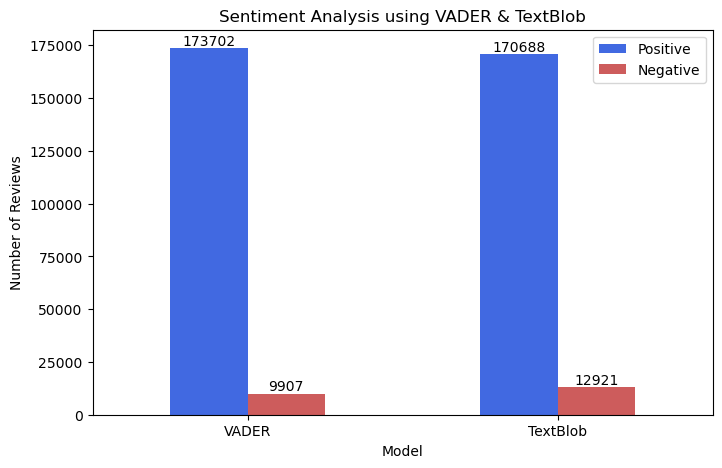

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
bar2 = pretrain_models.plot(kind='bar', x='Model', y=['Positive', 'Negative'], color=['royalblue', 'indianred'], ax=ax)

for bar in bar2.containers:
    bar2.bar_label(bar)
    
ax.set_title("Sentiment Analysis using VADER & TextBlob")
ax.set_xlabel("Model")
ax.set_ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

In [37]:
cleaned_news_df2.to_parquet("cleaned_sentiment_df.parquet")

##### BERT-based model

1. On sample data

In [48]:
sample_df = cleaned_news_df2.sample(n = 1000, random_state = 1)

In [49]:
%%time

# Load the RoBERTa model for zero-shot classification
classifier = pipeline("zero-shot-classification", model="roberta-large-mnli")

# Define candidate labels for sentiment analysis
candidate_labels = ["Positive", "Negative"]

# Define a function for sentiment prediction
def predict_sentiment_roberta(text):
    result = classifier(text, candidate_labels)
    return result["labels"][0]

# Apply the function to a sample of your data
sample_df['Sentiment_RoBERTa'] = sample_df['cleaned_text'].apply(predict_sentiment_roberta)

CPU times: total: 24min 31s
Wall time: 50min 51s


In [62]:
sample_df[['cleaned_text', 'Sentiment_VADER', 'Sentiment_TextBlob', 'Sentiment_RoBERTa']].sample(n = 5)

,cleaned_text,Sentiment_VADER,Sentiment_TextBlob,Sentiment_RoBERTa
173308,best liverpool xi ever named artificial intelligence mohamed salah left irish mirror online mobile newsirish newsnews unionufcother sportsport storiesfollow usirish newscelebrity newslatest usabout usadvertise uscontact uswork uscorrections codesgoogle surveycookie noticeprivacy noticeterms conditionshow mgn limited fc sportbest liverpool xi ever named artificial intelligence mohamed salah left outliverpool iconic figures world football anfield plenty trophies boast alongside fans might need...,Positive,Positive,Negative
73167,bold insight cosponsors depaul university grant program bridges ai ux localwatch wymt wymt weathermarch tornado classgreat health resultsstate results mapnational results mapback wireless sports overtimelocal top tentop playsuk sportsmeet teamcontact uscareers support localour mountain photos videosfull court press greta van country music lifestylegray dc givesstudent releasesbold insight cosponsors depaul university grant program bridges ai uxstudent teams present projects virtual oct edtup...,Positive,Positive,Negative
59420,companies avoid ethical pitfalls building ai products venturebeat main content venturebeat homepage events gamesbeat data pipeline transform account settings log become member sign venturebeat homepage venturebeat arvr big data cloud commerce dev enterprise entrepreneur marketing media mobile security social follow follow follow follow follow rss machine ai machine learning computer vision natural language processing robotic process automation follow follow rss gamesbeat games esports pc gam...,Positive,Positive,Positive
155177,elon musk enters ai industry xai ghacks tech news ghacksnet vpns windows linux software firefox chrome internet mobile computing companies misc deals vpns good know vpn streaming vpns gaming privacy news vpn reviews windows windows news windows help windows windows windows windows tips windows update linux linux mint software antivirus backup data recovery encryption file sharing microsoft office security firefox firefox addons chrome chrome extensions internet brave internet explorer micros...,Positive,Positive,Negative
30816,kami vision unveils ai visionbased fall alert system elder care contentsenior connecthome fear centerwatch fear weekendsubmit usmeet news teamlive onlinesee snap send itprevious newscastswect jobswect internship resultsgenx water jon evansschool sex alert skycamssky picsfirst alert hurricane night footballget fit contestcape fear weekendpet weekclear proscape fear morningfirst fourconserve cape fearside newscastsfull court press greta van county music lifestylegray dc tvpress releaseskami vi...,Positive,Positive,Negative


In [64]:
sample_df['Sentiment_RoBERTa'].value_counts()

Sentiment_RoBERTa
Negative    943
Positive     57
Name: count, dtype: int64

In [72]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [73]:
%time
zsl = ktrain.text.ZeroShotClassifier()

sentiments = []
for text in sample_df['cleaned_text']:
    res = zsl.predict(text, labels=['Negative', 'Positive'], 
                      include_labels=True,
                      multilabel=False, 
                      batch_size = 64)
    max_tuple = max(res, key=lambda x: x[1])
    sentiments.append(max_tuple[0])

sample_df['Sentiment_ZSL'] = sentiments

CPU times: total: 0 ns
Wall time: 0 ns


ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


Calculate accuracy

In [43]:
# Create manual label and add sentiment from techniques
accuracy_df = pd.DataFrame()

# Generate 1000 random labels (1 for Positive, 0 for Negative)
import random
random_labels = [random.choice([0, 1]) for _ in range(100)]
accuracy_df['manual_label'] = random_labels
accuracy_df.shape

(100, 1)

In [44]:
# Accuracy of VADER
news_sample_VADER = cleaned_news_df2[['Sentiment_VADER']].sample(n=100, random_state=42)

# Reset the index of both DataFrames to allow for a proper merge
news_sample_VADER.reset_index(drop=True, inplace=True)
accuracy_df.reset_index(drop=True, inplace=True)

# Merge the columns from 'news_sample_subset' into 'accuracy_df'
accuracy_VADER = pd.concat([accuracy_df, news_sample_VADER], axis=1)

# Convert the 'Sentiment_VADER' to binary values, where "Positive" is 1 and "Negative" is 0
accuracy_VADER['Sentiment_VADER_Binary'] = accuracy_VADER['Sentiment_VADER'].map({'Positive': 1, 'Negative': 0})

accuracy_VADER.head()

,manual_label,Sentiment_VADER,Sentiment_VADER_Binary
0,0,Positive,1
1,0,Positive,1
2,0,Positive,1
3,0,Positive,1
4,0,Positive,1


In [45]:
# Calculate the number of correct predictions
correct_predictions = (accuracy_VADER['manual_label'] == accuracy_VADER['Sentiment_VADER_Binary']).sum()

# Calculate accuracy as the number of correct predictions over the total number of predictions
total_predictions = len(accuracy_VADER)
accuracy = correct_predictions / total_predictions

print(f'Accuracy of VADER: {accuracy:.2f}')

Accuracy of VADER: 0.45


In [46]:
# Accuracy of Pre-trained
news_sample_TextBlob = cleaned_news_df2[['Sentiment_TextBlob']].sample(n=100, random_state=42)

# Reset the index of both DataFrames to allow for a proper merge
news_sample_TextBlob.reset_index(drop=True, inplace=True)
accuracy_df.reset_index(drop=True, inplace=True)

# Merge the columns from 'news_sample_subset' into 'accuracy_df'
accuracy_TextBlob = pd.concat([accuracy_df, news_sample_TextBlob], axis=1)

# Convert the 'Sentiment_VADER' to binary values, where "Positive" is 1 and "Negative" is 0
accuracy_TextBlob['Sentiment_TextBlob_Binary'] = accuracy_TextBlob['Sentiment_TextBlob'].map({'Positive': 1, 'Negative': 0})

accuracy_TextBlob.head()

,manual_label,Sentiment_TextBlob,Sentiment_TextBlob_Binary
0,0,Positive,1
1,0,Positive,1
2,0,Positive,1
3,0,Positive,1
4,0,Positive,1


In [47]:
# Calculate the number of correct predictions
correct_predictions = (accuracy_TextBlob['manual_label'] == accuracy_TextBlob['Sentiment_TextBlob_Binary']).sum()

# Calculate accuracy as the number of correct predictions over the total number of predictions
total_predictions = len(accuracy_TextBlob)
accuracy = correct_predictions / total_predictions

print(f'Accuracy of TextBlob: {accuracy:.2f}')

Accuracy of TextBlob: 0.41


In [204]:
# Accuracy of ZSL with BERT
news_sample_ZSL = sample_df[['Sentiment_ZSL']].sample(n=500, random_state=42)

# Reset the index of both DataFrames to allow for a proper merge
news_sample_ZSL.reset_index(drop=True, inplace=True)
accuracy_df.reset_index(drop=True, inplace=True)

# Merge the columns from 'news_sample_subset' into 'accuracy_df'
accuracy_ZSL = pd.concat([accuracy_df, news_sample_ZSL], axis=1)

# Convert the 'Sentiment_VADER' to binary values, where "Positive" is 1 and "Negative" is 0
accuracy_ZSL['Sentiment_ZSL_Binary'] = accuracy_ZSL['Sentiment_ZSL'].map({'positive': 1, 'negative': 0})

accuracy_ZSL.head()

,manual_label,Sentiment_ZSL,Sentiment_ZSL_Binary
0,1,positive,1
1,0,positive,1
2,0,positive,1
3,1,negative,0
4,0,positive,1


In [ ]:
# Calculate the number of correct predictions
correct_predictions = (accuracy_ZSL['manual_label'] == accuracy_ZSL['Sentiment_ZSL_Binary']).sum()

# Calculate accuracy as the number of correct predictions over the total number of predictions
total_predictions = len(accuracy_ZSL)
accuracy = correct_predictions / total_predictions

print(f'Accuracy of ZSL: {accuracy:.2f}')

Accuracy of ZSL: 0.52
